# Used Car Price Prediction

## Problem Definition

This is a regression project which predicts the price of used cars based on the year purchased, mileage, city the car was sold, state the car was sold, VIN, manufacturer and model of the car.

The dataset was obtained from https://www.kaggle.com/datasets/harikrishnareddyb/used-car-price-predictions

## Data Preprocessing 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import patsy

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In [2]:
#importing the data
used = pd.read_csv('true_car_listings.csv')
used.head(5)

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


### Data Cleaning

In [3]:
used.dtypes

Price       int64
Year        int64
Mileage     int64
City       object
State      object
Vin        object
Make       object
Model      object
dtype: object

In [4]:
#check for missing data
used.isna().sum(axis=0)

Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

In [5]:
#check for number of unique values
used.nunique()

Price       47124
Year           22
Mileage    158836
City         2553
State          59
Vin        852075
Make           58
Model        2736
dtype: int64

In [6]:
#There should only be 51 states
used['State'].unique()

array([' TX', ' NY', ' CO', ' UT', ' FL', ' CT', ' ID', ' ND', ' CA',
       ' NJ', ' OH', ' VA', ' IN', ' AZ', ' OR', ' KS', ' NE', ' MA',
       ' MD', ' GA', ' MN', ' HI', ' LA', ' NM', ' IL', ' AL', ' PA',
       ' SC', ' NC', ' WA', ' WI', ' OK', ' KY', ' MS', ' MO', ' ME',
       ' AR', ' MI', ' NV', ' TN', ' Fl', ' NH', ' DE', ' WV', ' Az',
       ' VT', ' SD', ' IA', ' RI', ' ga', ' Oh', ' MT', ' DC', ' AK',
       ' Va', ' WY', ' Md', ' Ca', ' Ga'], dtype=object)

In [7]:
used['State'] = used['State'].str.upper()
used['State'].nunique()

51

In [8]:
#Used cars from 1997-2018
years = sorted(used['Year'].unique())
years

[1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018]

In [9]:
#There are casing duplicates for 'City' (2408 vs 2553)
used['City'].str.capitalize().nunique()

2408

In [10]:
used['City'] = used['City'].str.capitalize()

In [11]:
#No casing duplicates for 'Make'
used['Make'].str.upper().nunique()

58

In [12]:
#There are casing duplicates for 'Model' (2699 vs 2736)
used['Model'].str.upper().nunique()

2699

In [13]:
used['Model'] = used['Model'].str.upper()

In [14]:
used.head(5)

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El paso,TX,19VDE2E53EE000083,Acura,ILX6-SPEED
1,10888,2013,19606,Long island city,NY,19VDE1F52DE012636,Acura,ILX5-SPEED
2,8995,2013,48851,El paso,TX,19VDE2E52DE000025,Acura,ILX6-SPEED
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-SPEED
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAUTOMATIC


## Exploratory Data Analysis

In [15]:
used.describe()

,Price,Year,Mileage
count,852122.000000,852122.000000,8.521220e+05
mean,21464.100210,2013.289145,5.250779e+04
std,13596.202241,3.414987,4.198896e+04
min,1500.000000,1997.000000,5.000000e+00
25%,13000.000000,2012.000000,2.383600e+04
50%,18500.000000,2014.000000,4.025600e+04
75%,26995.000000,2016.000000,7.218600e+04
max,499500.000000,2018.000000,2.856196e+06


### Univariate Analysis of Price

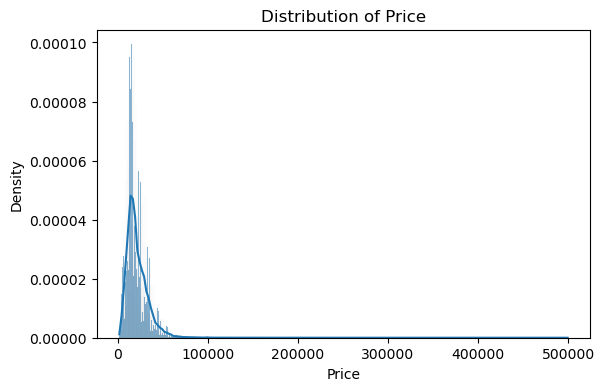

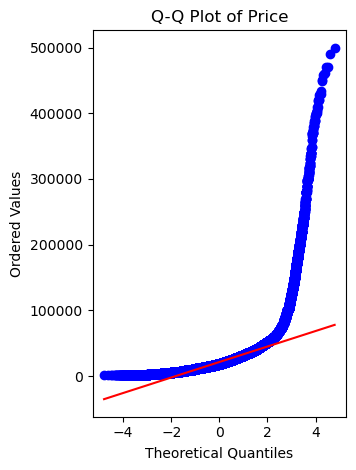

In [16]:
#With outliers
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(used['Price'], kde=True, stat='density')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(used['Price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Price')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

We observe that the values significantly deviate from the diagonal line once they go beyond the 2nd quantile.

In [17]:
#Getting rid of outliers as it skews the distribution
Q1 = used['Price'].quantile(0.25)
Q3 = used['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

used = used[(used['Price'] >= lower_bound) & (used['Price'] <= upper_bound)]

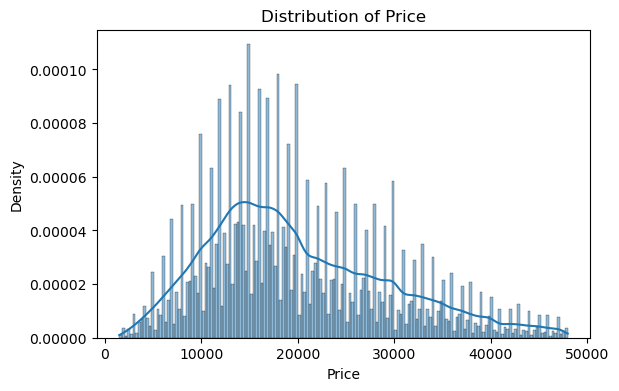

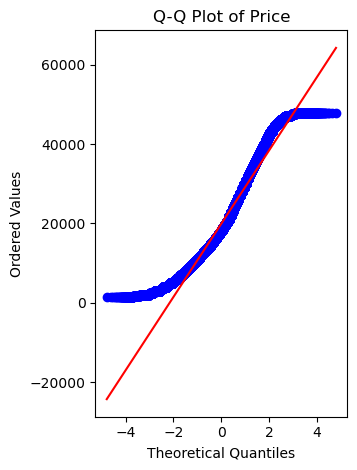

In [18]:
#Without outliers
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
sns.histplot(used['Price'], kde=True, stat='density')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

plt.subplot(1, 2, 2)
stats.probplot(used['Price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Price')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

We observe that 'Price' is right-skewed and is centered at about $15,000. This indicates that the 'Price' of used cars tend to be on the lower end of the spectrum.

The Q-Q plot is S-shaped, indicating that 'Price' is now roughly normally distributed (right-skewed).

### Univariate Analysis of Mileage

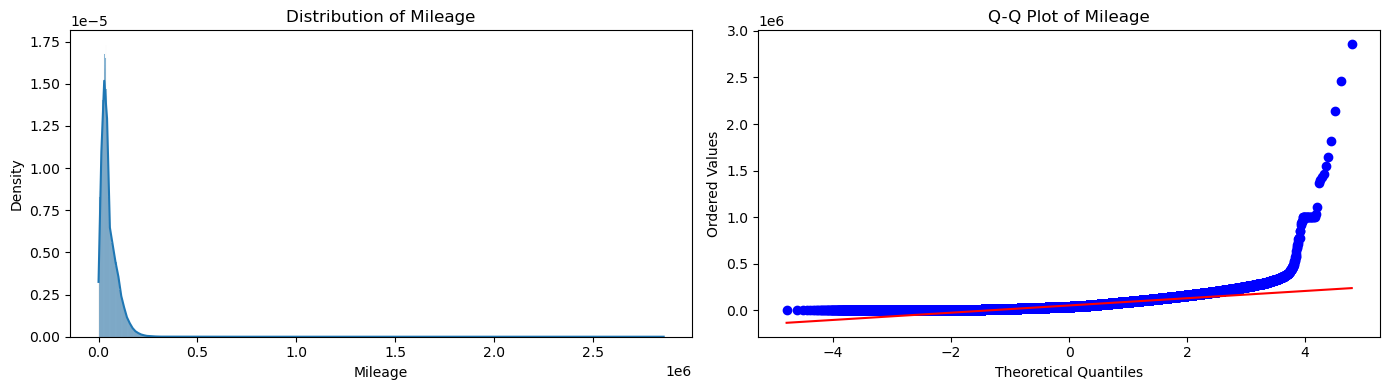

In [19]:
#With outliers
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(used['Mileage'], kde=True, stat='density')
plt.title('Distribution of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Density')

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(used['Mileage'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Mileage')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

We observe that the values significantly deviate from the diagonal line once they go beyond the 4th quantile.

In [20]:
#Getting rid of outliers as it skews the distribution
Q1 = used['Mileage'].quantile(0.25)
Q3 = used['Mileage'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

used = used[(used['Mileage'] >= lower_bound) & (used['Mileage'] <= upper_bound)]

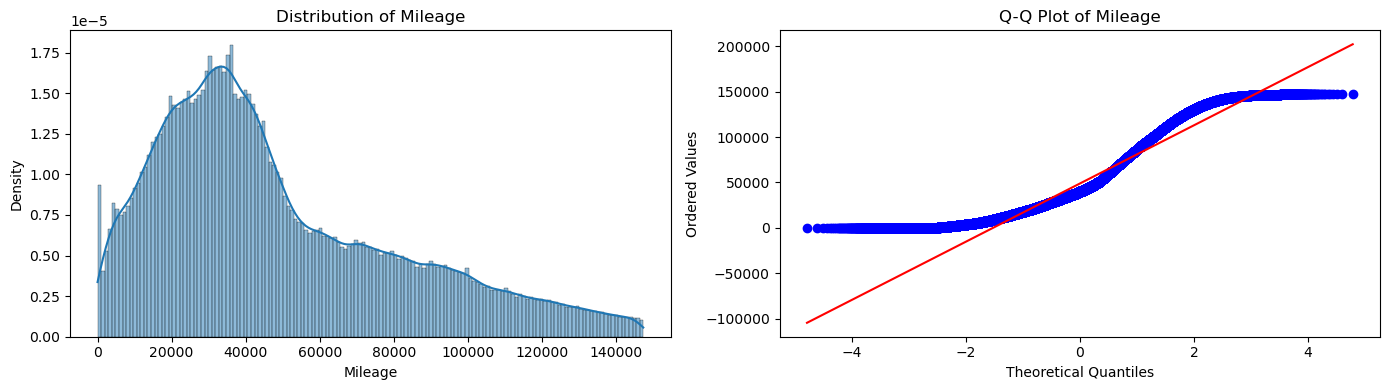

In [21]:
#Without outliers
plt.figure(figsize=(14, 4))

#histogram
plt.subplot(1, 2, 1)
sns.histplot(used['Mileage'], kde=True, stat='density')
plt.title('Distribution of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Density')

#Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(used['Mileage'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Mileage')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

We observe that 'Mileage' is right-skewed and is centered at about 35000. This indicates that the 'Mileage' of used cars tend to be on the lower end of the spectrum.

The Q-Q plot is S-shaped, indicating that 'Mileage' is now roughly normally distributed (right-skewed).

### Univariate Analysis of Year

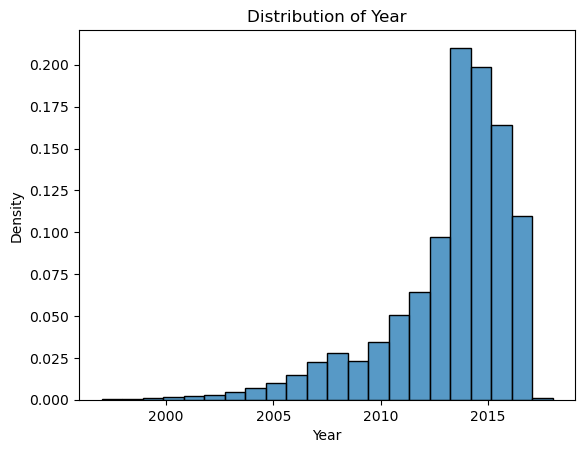

In [22]:
sns.histplot(used['Year'], bins=22, stat='density')
plt.title('Distribution of Year')
plt.xlabel('Year')
plt.ylabel('Density')
plt.show()

We observe that 'Year' is left-skewed which indicates that most of the used cars were purchased in more recent years.

### Bivariate Analysis

In [23]:
used.corr()

,Price,Year,Mileage
Price,1.000000,0.463557,-0.479168
Year,0.463557,1.000000,-0.748394
Mileage,-0.479168,-0.748394,1.000000


<AxesSubplot:>

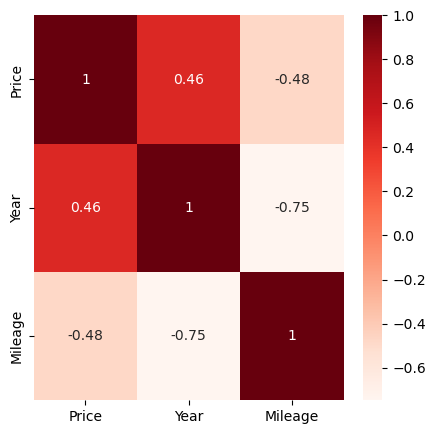

In [24]:
plt.figure(figsize = (5,5))
sns.heatmap(used.corr(), annot=True, cmap='Reds')

Price and Mileage are moderately negatively correlated with coefficient of -0.48

Price and Year are moderately positively correlated with coefficient of 0.46

Year and Mileage are strongly negatively correlated with coefficient of -0.75 which might indicate an imperfect multicollinearity

In [25]:
#VIF to assess multicollinearity
col = used[['Year', 'Mileage']]
const = add_constant(col)

# Compute VIF for each predictor
vif = pd.DataFrame()
vif["Predictor"] = const.columns
vif["VIF"] = [variance_inflation_factor(const.values, i) for i in range(const.shape[1])]

vif['VIF'].iloc[1]

2.2732088163890625

We obtain a VIF of 2.27, indicating that there is multicollinearity between Year and Mileage. However, since the value is still below 5, this multicollinearity is not problematic and we can ignore it.

## Model

### Baseline Model

In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), ['Mileage']),
        ('min-max', MinMaxScaler(), ['Year']),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'), ['City', 'State', 'Make', 'Model', 'Vin'])
    ],
    remainder='passthrough'
)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(used.drop(columns=['Price']), used['Price'], test_size=0.25, random_state=1)

In [28]:
pl = make_pipeline(preprocessor, LinearRegression())
pl.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', StandardScaler(),
                                                  ['Mileage']),
                                                 ('min-max', MinMaxScaler(),
                                                  ['Year']),
                                                 ('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['City', 'State', 'Make',
                                                   'Model', 'Vin'])])),
                ('linearregression', LinearRegression())])

In [29]:
y_pred = pl.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('Test RMSE:', rmse)
print('Test R-Squared:', r2)

Test RMSE: 3211.922874025127
Test R-Squared: 0.8801156753425319


### Feature Selection

In [30]:
#drop 'Vin' column since it is an irrelevant unique nominal variable
used = used.drop(columns=['Vin'])
used.head(5)

,Price,Year,Mileage,City,State,Make,Model
0,8995,2014,35725,El paso,TX,Acura,ILX6-SPEED
1,10888,2013,19606,Long island city,NY,Acura,ILX5-SPEED
2,8995,2013,48851,El paso,TX,Acura,ILX6-SPEED
3,10999,2014,39922,Windsor,CO,Acura,ILX5-SPEED
4,14799,2016,22142,Lindon,UT,Acura,ILXAUTOMATIC


I am unable to conduct OLS regression due to the size of the data.

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), ['Mileage']),
        ('min-max', MinMaxScaler(), ['Year']),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'), ['City', 'State', 'Make', 'Model'])
    ],
    remainder='passthrough'
)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(used.drop(columns=['Price']), used['Price'], test_size=0.25, random_state=1)

In [33]:
pl = make_pipeline(preprocessor, LinearRegression())
pl.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', StandardScaler(),
                                                  ['Mileage']),
                                                 ('min-max', MinMaxScaler(),
                                                  ['Year']),
                                                 ('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['City', 'State', 'Make',
                                                   'Model'])])),
                ('linearregression', LinearRegression())])

In [34]:
y_pred = pl.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('Test RMSE:', rmse)
print('Test R-Squared:', r2)

Test RMSE: 3210.0505201298165
Test R-Squared: 0.8802554050098647


### Alternative Model

Try Ridge Regression to mitigate the multicollinearity.

In [35]:
pl_ridge = make_pipeline(preprocessor, Ridge())
pl_ridge.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', StandardScaler(),
                                                  ['Mileage']),
                                                 ('min-max', MinMaxScaler(),
                                                  ['Year']),
                                                 ('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['City', 'State', 'Make',
                                                   'Model'])])),
                ('ridge', Ridge())])

In [36]:
y_pred = pl_ridge.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('Test RMSE:', rmse)
print('Test R-Squared:', r2)

Test RMSE: 3227.068360399628
Test R-Squared: 0.8789824057318829


Tuning with hyperparameters

In [37]:
alpha_hyperparameters = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pl_ridge, alpha_hyperparameters, cv=8, scoring='neg_mean_squared_error', n_jobs=8)
grid.fit(x_train, y_train)
best_alpha = grid.best_params_['ridge__alpha']
best_alpha

0.1

In [38]:
optimal_ridge = grid.best_estimator_
y_pred = optimal_ridge.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('Test RMSE:', rmse)
print('Test R-Squared:', r2)

Test RMSE: 3225.1141882395787
Test R-Squared: 0.8791289273319258


It seems that Linear Regression still gives us the best result.

### Final Model

**Model**: Linear Regression </br>
**RMSE**: 3210.0505201298165 </br>
**R-squared**: 0.8802554050098647 </br>
**Features**: Price, Year, Mileage, City, State, Make, Model </br>